In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the telemetry data
telemetry_path = Path("output/CT Annotations - Telemetry.csv")
df = pd.read_csv(telemetry_path)

print(f"Total records: {len(df)}")
print(f"\nData columns: {list(df.columns)}")
print(f"\nEvent types: {df['type'].value_counts().to_dict()}")
print(f"\nFirst few rows:")
df.head()

Total records: 207

Data columns: ['ts', 'serverTs', 'type', 'sessionId', 'datasetId', 'labeler', 'imagePath', 'classification', 'responseTimeMs', 'serverDurationMs', 'success', 'minutes', 'labeled', 'throughputPerMin', 'memoryMB', 'ua', 'error']

Event types: {'classify': 205, 'page_load': 1, 'sample': 1}

First few rows:


,ts,serverTs,type,sessionId,datasetId,labeler,imagePath,classification,responseTimeMs,serverDurationMs,success,minutes,labeled,throughputPerMin,memoryMB,ua,error
0,1761535214390,1761535220979,page_load,1761535208747-0j9cuu484rs5,triaging-data,ron,NaN,NaN,NaN,5620.6,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN
1,1761535243241,1761535244064,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/0/CT000017.png,Low Risk,1730.5,1730.5,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN
2,1761535250792,1761535251615,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/1/CT000020.png,Low Risk,1833.0,1833.0,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN
3,1761535258428,1761535259285,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/1/CT000020.png,High Risk,891.6,891.6,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN
4,1761535264202,1761535265080,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/10/CT000107.png,Low Risk,760.6,760.5,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN


In [58]:
# Data preprocessing
# Convert timestamps from milliseconds to datetime
df['timestamp'] = pd.to_datetime(df['ts'], unit='ms')
df['serverTimestamp'] = pd.to_datetime(df['serverTs'], unit='ms')

# Convert success column to boolean
df['success'] = df['success'].astype(str).str.upper() == 'TRUE'

# Sort by timestamp to ensure chronological order
df = df.sort_values('timestamp').reset_index(drop=True)

# Remove duplicate records sharing the same imagePath (keep earliest by timestamp)
duplicate_rows = df['imagePath'].notna() & df.duplicated(subset=['imagePath'], keep='first')
duplicate_count = int(duplicate_rows.sum())
if duplicate_count:
    print(f"⚠️  Removed {duplicate_count} duplicate records with the same imagePath")
    df = df.loc[~duplicate_rows].reset_index(drop=True)
else:
    print("✓ No duplicate imagePath records found")

# Preserve a copy of the full session for metrics that need every action
df_full = df.copy()

# Limit to first 200 classification cases
MAX_CLASSIFICATION_CASES = 300
classify_events_all = df[df['type'] == 'classify'].copy()
if len(classify_events_all) > MAX_CLASSIFICATION_CASES:
    # Get the first 200 classification events by timestamp
    classify_events_limited = classify_events_all.head(MAX_CLASSIFICATION_CASES)
    # Get the timestamp of the last classification event we're including
    last_classify_timestamp = classify_events_limited['timestamp'].max()
    # Filter the main dataframe to include all events up to and including the last classification
    # This ensures we include page_load and sample events that occurred during the 200 cases
    df = df[df['timestamp'] <= last_classify_timestamp].copy()
    print(f"⚠️  Limited analysis to first {MAX_CLASSIFICATION_CASES} classification cases")
    print(f"   Total events in analysis: {len(df)}")
else:
    print(f"✓  Using all {len(classify_events_all)} classification cases")

print(f"\nTime range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total duration: {(df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 60:.2f} minutes")

⚠️  Removed 25 duplicate records with the same imagePath
✓  Using all 175 classification cases

Time range: 2025-10-27 03:20:14.390000 to 2025-10-27 03:40:56.975000
Total duration: 20.71 minutes


In [59]:
df = df[df['type'] != 'sample']
len(df)

176

In [60]:
for i in range(1, len(df)):
    df.loc[df.index[i], "thinkingTimeMs"]= (df.iloc[i]['timestamp'] - df.iloc[i-1]['timestamp']).total_seconds() * 1000

In [61]:
df

,ts,serverTs,type,sessionId,datasetId,labeler,imagePath,classification,responseTimeMs,serverDurationMs,success,minutes,labeled,throughputPerMin,memoryMB,ua,error,timestamp,serverTimestamp,thinkingTimeMs
0,1761535214390,1761535220979,page_load,1761535208747-0j9cuu484rs5,triaging-data,ron,NaN,NaN,NaN,5620.6,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:20:14.390,2025-10-27 03:20:20.979,NaN
1,1761535243241,1761535244064,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/0/CT000017.png,Low Risk,1730.5,1730.5,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:20:43.241,2025-10-27 03:20:44.064,28851.0
2,1761535250792,1761535251615,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/1/CT000020.png,Low Risk,1833.0,1833.0,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:20:50.792,2025-10-27 03:20:51.615,7551.0
3,1761535264202,1761535265080,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/10/CT000107.png,Low Risk,760.6,760.5,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:21:04.202,2025-10-27 03:21:05.080,13410.0
4,1761535268162,1761535269041,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/100/CT000031.png,Low Risk,810.7,810.6,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:21:08.162,2025-10-27 03:21:09.041,3960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,1761536422419,1761536422618,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/259/CT000029.png,Low Risk,672.1,671.9,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:40:22.419,2025-10-27 03:40:22.618,12534.0
172,1761536426657,1761536426914,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/26/CT000008.png,Low Risk,753.9,753.8,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:40:26.657,2025-10-27 03:40:26.914,4238.0
173,1761536435965,1761536436166,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/260/CT000013.png,Unclear,537.3,537.3,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:40:35.965,2025-10-27 03:40:36.166,9308.0
174,1761536448715,1761536448921,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/261/CT000002.png,Low Risk,659.5,659.5,True,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:40:48.715,2025-10-27 03:40:48.921,12750.0


Analyzing 175 classification cases
RESPONSE TIME PER CASE (ms)
Average Response Time: 7100.49 ms
Median Response Time: 4266.00 ms
Min Response Time: 2234.00 ms
Max Response Time: 91892.00 ms
Standard Deviation: 11464.79 ms
Total Classification Events: 175


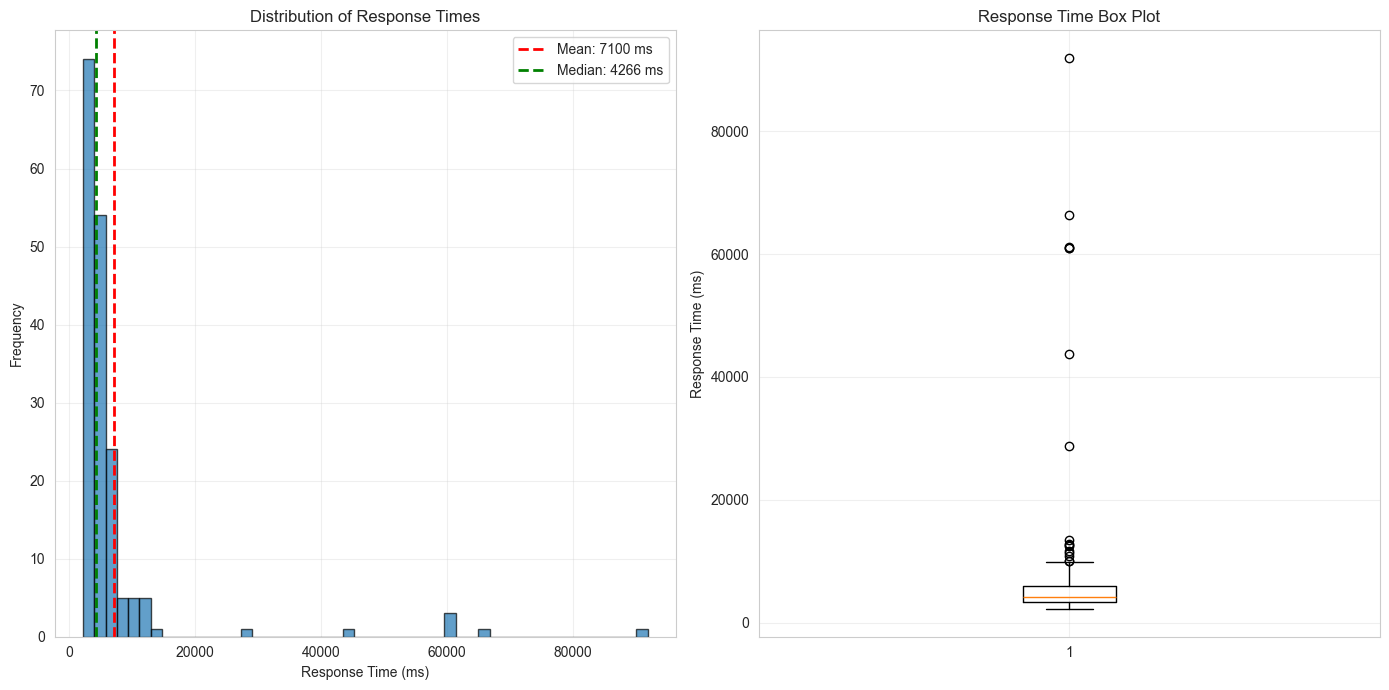

In [62]:
# Filter classification events (already limited to 200 in preprocessing)
classify_events = df[df['type'] == 'classify'].copy()

print(f"Analyzing {len(classify_events)} classification cases")

# Calculate response time per case
# responseTimeMs already contains the time between image load and submission
response_times = classify_events['thinkingTimeMs'].dropna()

# Calculate statistics
avg_response_time = response_times.mean()
median_response_time = response_times.median()
min_response_time = response_times.min()
max_response_time = response_times.max()
std_response_time = response_times.std()

print("=" * 60)
print("RESPONSE TIME PER CASE (ms)")
print("=" * 60)
print(f"Average Response Time: {avg_response_time:.2f} ms")
print(f"Median Response Time: {median_response_time:.2f} ms")
print(f"Min Response Time: {min_response_time:.2f} ms")
print(f"Max Response Time: {max_response_time:.2f} ms")
print(f"Standard Deviation: {std_response_time:.2f} ms")
print(f"Total Classification Events: {len(response_times)}")

# Visualize response time distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Histogram
axes[0].hist(response_times, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(avg_response_time, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_response_time:.0f} ms')
axes[0].axvline(median_response_time, color='green', linestyle='--', linewidth=2, label=f'Median: {median_response_time:.0f} ms')
axes[0].set_xlabel('Response Time (ms)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Response Times')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot (excluding outliers for better visualization)
q1 = response_times.quantile(0.25)
q3 = response_times.quantile(0.75)
iqr = q3 - q1
# outlier_threshold = q3 + 3 * iqr
# filtered_times = response_times[response_times <= outlier_threshold]

axes[1].boxplot(response_times, vert=True)
axes[1].set_ylabel('Response Time (ms)')
axes[1].set_title('Response Time Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Note about outliers
# outlier_count = len(response_times[response_times > outlier_threshold])
# if outlier_count > 0:
#     print(f"\nNote: {outlier_count} outliers (> {outlier_threshold:.0f} ms) excluded from box plot")

In [67]:
successful_classifications

,ts,serverTs,type,sessionId,datasetId,labeler,imagePath,classification,responseTimeMs,serverDurationMs,...,minutes,labeled,throughputPerMin,memoryMB,ua,error,timestamp,serverTimestamp,thinkingTimeMs,minute
1,1761535243241,1761535244064,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/0/CT000017.png,Low Risk,1730.5,1730.5,...,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:20:43.241,2025-10-27 03:20:44.064,28851.0,0
2,1761535250792,1761535251615,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/1/CT000020.png,Low Risk,1833.0,1833.0,...,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:20:50.792,2025-10-27 03:20:51.615,7551.0,0
3,1761535264202,1761535265080,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/10/CT000107.png,Low Risk,760.6,760.5,...,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:21:04.202,2025-10-27 03:21:05.080,13410.0,0
4,1761535268162,1761535269041,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/100/CT000031.png,Low Risk,810.7,810.6,...,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:21:08.162,2025-10-27 03:21:09.041,3960.0,0
5,1761535272281,1761535273149,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/101/CT000022.png,Low Risk,521.5,521.5,...,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:21:12.281,2025-10-27 03:21:13.149,4119.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,1761536422419,1761536422618,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/259/CT000029.png,Low Risk,672.1,671.9,...,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:40:22.419,2025-10-27 03:40:22.618,12534.0,19
172,1761536426657,1761536426914,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/26/CT000008.png,Low Risk,753.9,753.8,...,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:40:26.657,2025-10-27 03:40:26.914,4238.0,19
173,1761536435965,1761536436166,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/260/CT000013.png,Unclear,537.3,537.3,...,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:40:35.965,2025-10-27 03:40:36.166,9308.0,19
174,1761536448715,1761536448921,classify,1761535208747-0j9cuu484rs5,triaging-data,ron,data/mls-data/261/CT000002.png,Low Risk,659.5,659.5,...,NaN,NaN,NaN,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaN,2025-10-27 03:40:48.715,2025-10-27 03:40:48.921,12750.0,20


In [77]:
cases_each_minute.index

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20],
      dtype='int64', name='minute')

1 10
2 12.5
3 8.666666666666666
4 9.75
5 9.8
6 9.0
7 9.142857142857142
8 8.75
9 8.222222222222221
10 8.3
11 8.818181818181818
12 8.5
13 8.384615384615385
14 8.714285714285714
15 8.2
16 8.1875
17 8.411764705882353
18 8.38888888888889
19 8.631578947368421
20 8.65
THROUGHPUT (cases/min)
Total Successful Classifications: 175
Total Duration: 20.71 minutes
Overall Throughput: 8.45 cases/min
Average Throughput per Minute: 8.95 cases/min
Median Throughput per Minute: 8.66 cases/min
Max Throughput per Minute: 12.50 cases/min
Min Throughput per Minute: 8.19 cases/min


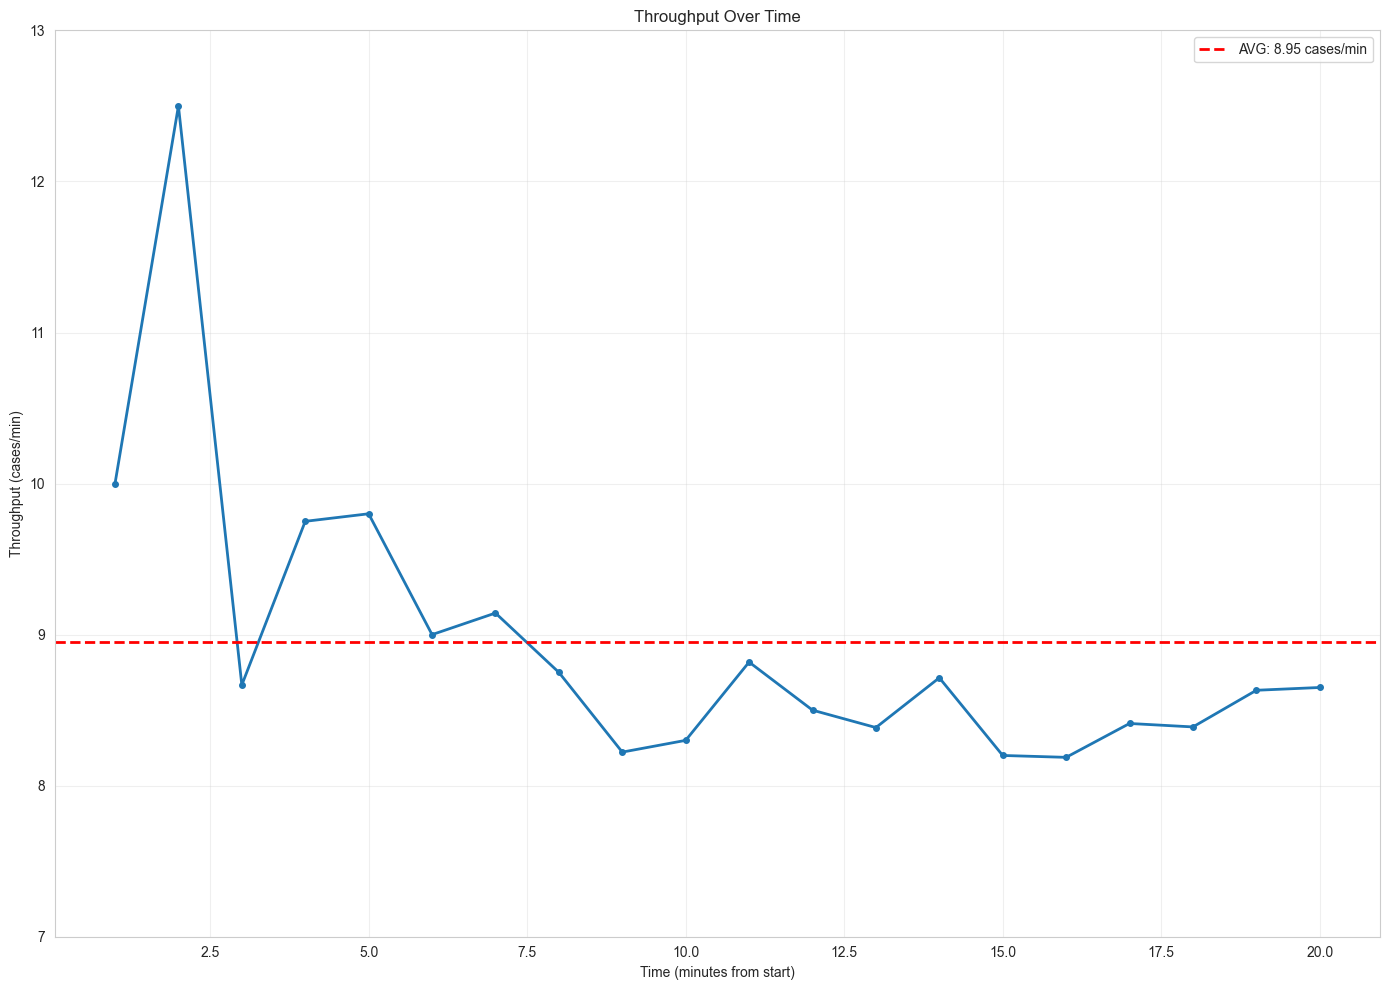

In [86]:
# Calculate throughput
# Filter successful classification events
successful_classifications = classify_events[classify_events['success'] == True].copy()

# Calculate total time span in minutes
total_duration_minutes = (df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 60

# Calculate total successful classifications
total_successful = len(successful_classifications)

# Overall throughput
overall_throughput = total_successful / total_duration_minutes if total_duration_minutes > 0 else 0

# Calculate throughput per minute using time windows
# Group by minute intervals
successful_classifications['minute'] = (successful_classifications['timestamp'] - successful_classifications['timestamp'].min()).dt.total_seconds() // 60
successful_classifications['minute'] = successful_classifications['minute'].astype(int)

cases_each_minute = successful_classifications.groupby(successful_classifications['minute'])['timestamp'].count()

throughput_per_minute = []
current_sum = 0
for i in range(1, cases_each_minute.index.max() + 1):
    if i == 1:
        throughput_per_minute.append(cases_each_minute.iloc[i - 1])
    else:
        throughput_per_minute.append((cases_each_minute.iloc[i - 1] + current_sum) / i)

    current_sum += cases_each_minute.iloc[i - 1]

    print(i, throughput_per_minute[-1])

throughput_per_minute = pd.Series(throughput_per_minute, index=cases_each_minute.index[1:])

print("=" * 60)
print("THROUGHPUT (cases/min)")
print("=" * 60)
print(f"Total Successful Classifications: {total_successful}")
print(f"Total Duration: {total_duration_minutes:.2f} minutes")
print(f"Overall Throughput: {overall_throughput:.2f} cases/min")
print(f"Average Throughput per Minute: {throughput_per_minute.mean():.2f} cases/min")
print(f"Median Throughput per Minute: {throughput_per_minute.median():.2f} cases/min")
print(f"Max Throughput per Minute: {throughput_per_minute.max():.2f} cases/min")
print(f"Min Throughput per Minute: {throughput_per_minute.min():.2f} cases/min")

# Visualize throughput over time
fig, axes = plt.subplots(1, 1, figsize=(14, 10))

# Throughput over time
axes.plot(throughput_per_minute.index, throughput_per_minute.values, marker='o', linewidth=2, markersize=4)
axes.axhline(throughput_per_minute.mean(), color='red', linestyle='--', linewidth=2, label=f'AVG: {throughput_per_minute.mean():.2f} cases/min')
axes.set_xlabel('Time (minutes from start)')
axes.set_ylabel('Throughput (cases/min)')
axes.set_title('Throughput Over Time')
axes.set_ylim(7, 13)
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

283571.0
959014.0
IDLE/ACTIVE RATIO
Total Time: 20.71 minutes (1242.59 seconds)
Active Time (sum of response times): 4.73 minutes (283.57 seconds)
Idle Time (gaps between events): 15.53 minutes (931.89 seconds)
Alternative Idle Time (total - active): 15.98 minutes (959.01 seconds)

Active Ratio: 22.82%
Idle Ratio: 75.00%
Idle/Active Ratio: 3.29


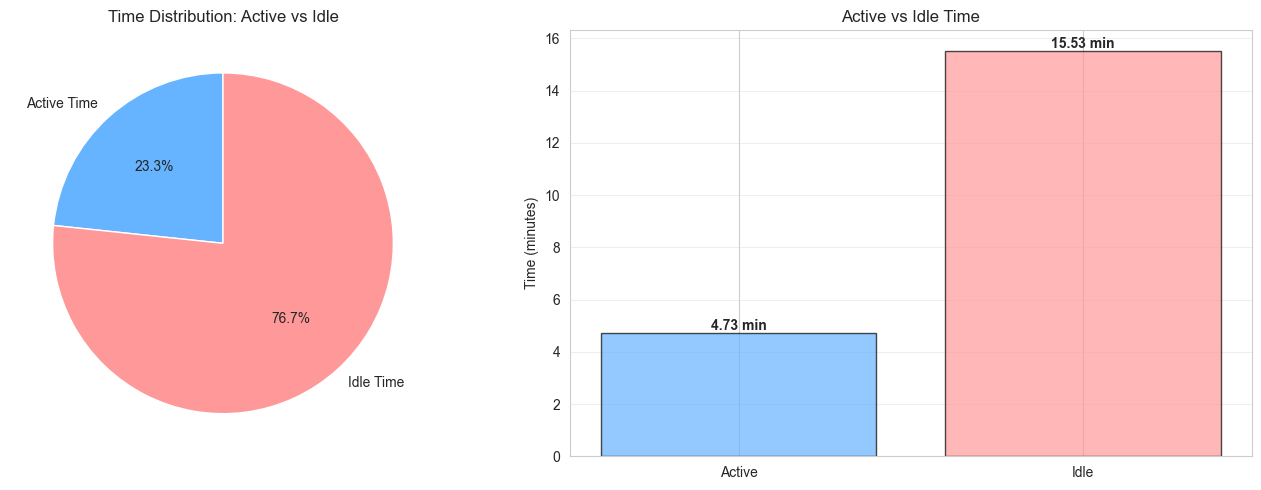

In [64]:
# Calculate idle/active ratio
# Active time: sum of response times for all classification events => This is the time that the user is actively annotating by clicking the buttons and waiting for the server to respond
active_time_ms = (classify_events['responseTimeMs']).sum()

print(active_time_ms)

# Calculate idle time: time gaps between consecutive classification events
classify_events_sorted = classify_events.sort_values('timestamp').reset_index(drop=True)
if len(classify_events_sorted) > 1:
    # Idle time is the gap between events minus the response time of the current event
    # For each gap, subtract the response time to get true idle time
    idle_time_ms = 0
    for i in range(1, len(classify_events_sorted)):
        gap_ms = (classify_events_sorted.iloc[i]['timestamp'] - classify_events_sorted.iloc[i-1]['timestamp']).total_seconds() * 1000
        prev_response_time = classify_events_sorted.iloc[i]['responseTimeMs']
        if gap_ms < prev_response_time:
            print("Case:", i, "Gap:", gap_ms, "Response time:", prev_response_time)
        if pd.notna(prev_response_time):
            idle_time_ms += max(0, gap_ms - prev_response_time)
else:
    idle_time_ms = 0

# Total time: time from first to last event
total_time_ms = (df['timestamp'].max() - df['timestamp'].min()).total_seconds() * 1000

# Alternative calculation: total time - active time (for comparison)
idle_time_alt_ms = total_time_ms - active_time_ms
print(idle_time_alt_ms)

# Calculate ratios
active_ratio = (active_time_ms / total_time_ms) * 100 if total_time_ms > 0 else 0
idle_ratio = (idle_time_ms / total_time_ms) * 100 if total_time_ms > 0 else 0
idle_active_ratio = idle_time_ms / active_time_ms if active_time_ms > 0 else 0

print("=" * 60)
print("IDLE/ACTIVE RATIO")
print("=" * 60)
print(f"Total Time: {total_time_ms / 1000 / 60:.2f} minutes ({total_time_ms / 1000:.2f} seconds)")
print(f"Active Time (sum of response times): {active_time_ms / 1000 / 60:.2f} minutes ({active_time_ms / 1000:.2f} seconds)")
print(f"Idle Time (gaps between events): {idle_time_ms / 1000 / 60:.2f} minutes ({idle_time_ms / 1000:.2f} seconds)")
print(f"Alternative Idle Time (total - active): {idle_time_alt_ms / 1000 / 60:.2f} minutes ({idle_time_alt_ms / 1000:.2f} seconds)")
print(f"\nActive Ratio: {active_ratio:.2f}%")
print(f"Idle Ratio: {idle_ratio:.2f}%")
print(f"Idle/Active Ratio: {idle_active_ratio:.2f}")

# Visualize time distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
labels = ['Active Time', 'Idle Time']
sizes = [active_time_ms, idle_time_ms]
colors = ['#66b3ff', '#ff9999']
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Time Distribution: Active vs Idle')

# Bar chart
categories = ['Active', 'Idle']
time_minutes = [active_time_ms / 1000 / 60, idle_time_ms / 1000 / 60]
axes[1].bar(categories, time_minutes, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Time (minutes)')
axes[1].set_title('Active vs Idle Time')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(time_minutes):
    axes[1].text(i, v, f'{v:.2f} min', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

CLASSIFICATION SUCCESS RATE (%)
Total Classification Attempts: 200
Successful Classifications: 200
Failed Classifications: 0
Success Rate: 100.00%


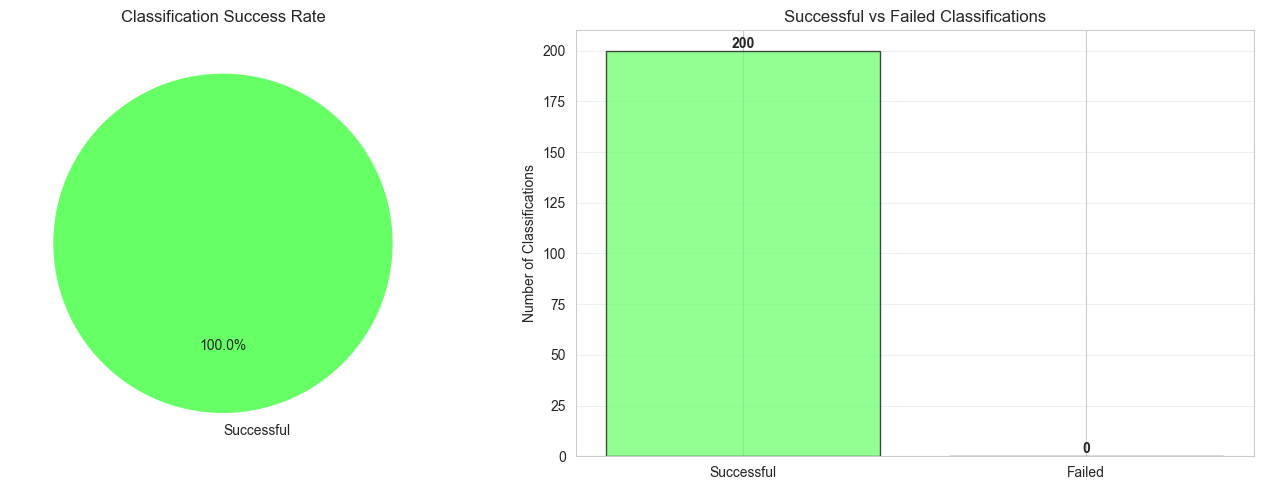

In [14]:
# Calculate classification success rate
total_classification_attempts = len(classify_events)
successful_classifications_count = len(classify_events[classify_events['success'] == True])
failed_classifications_count = len(classify_events[classify_events['success'] == False])

success_rate = (successful_classifications_count / total_classification_attempts * 100) if total_classification_attempts > 0 else 0

print("=" * 60)
print("CLASSIFICATION SUCCESS RATE (%)")
print("=" * 60)
print(f"Total Classification Attempts: {total_classification_attempts}")
print(f"Successful Classifications: {successful_classifications_count}")
print(f"Failed Classifications: {failed_classifications_count}")
print(f"Success Rate: {success_rate:.2f}%")

# Visualize success rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
labels = ['Successful', 'Failed']
sizes = [successful_classifications_count, failed_classifications_count]
colors = ['#66ff66', '#ff6666']
if failed_classifications_count > 0:
    axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
else:
    axes[0].pie([successful_classifications_count], labels=['Successful'], colors=['#66ff66'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Classification Success Rate')

# Bar chart
categories = ['Successful', 'Failed']
counts = [successful_classifications_count, failed_classifications_count]
axes[1].bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Number of Classifications')
axes[1].set_title('Successful vs Failed Classifications')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(counts):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

MEMORY FOOTPRINT (MB) — FULL SESSION
Average Memory Usage: 18.20 MB
Median Memory Usage: 18.20 MB
Min Memory Usage: 18.20 MB
Max Memory Usage: 18.20 MB
Standard Deviation: 0.00 MB

Data Coverage:
  Actual Memory Measurements: 1
  Estimated Values (forward-filled): 201
  Total Events Analyzed: 202
  Memory samples by event type: {'sample': 1}


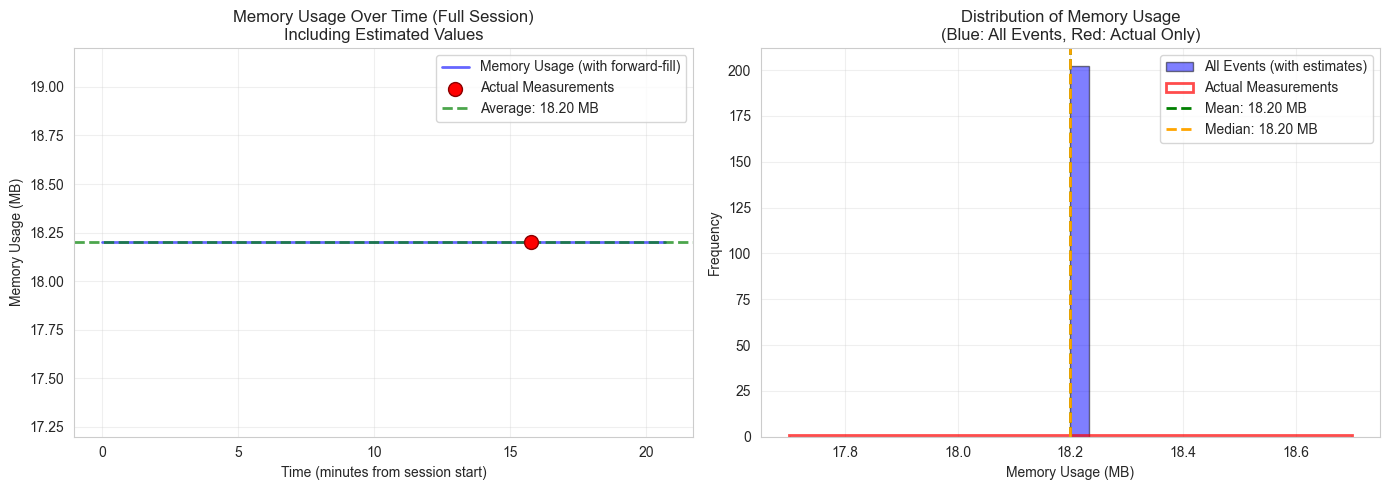


Note: Memory values estimated using forward-fill for 201 events without measurements
      Analysis covers 20.71 minutes of session with 202 total events


In [19]:
# Calculate memory footprint using the full session (all actions)
# Collect memory data from ALL event types, not just 'sample'
df_for_memory = df_full if 'df_full' in globals() else df

# Sort by timestamp to ensure chronological order
df_for_memory = df_for_memory.sort_values('timestamp').reset_index(drop=True).copy()

# Fill NA memory values using forward-fill and backward-fill
# This estimates memory usage for events that don't have memory logged
df_for_memory['memoryMB_filled'] = df_for_memory['memoryMB'].copy()

# First, forward-fill (carry last known value forward)
df_for_memory['memoryMB_filled'] = df_for_memory['memoryMB_filled'].ffill()

# Then, backward-fill (fill initial NAs with first known value)
df_for_memory['memoryMB_filled'] = df_for_memory['memoryMB_filled'].bfill()

# Get actual measured memory data (for reference)
all_memory_events = df_for_memory[df_for_memory['memoryMB'].notna()].copy()
memory_data_actual = all_memory_events['memoryMB'].dropna()

# Get filled memory data (includes estimated values)
memory_data_filled = df_for_memory['memoryMB_filled'].dropna()

# Initialize variables
avg_memory = None
median_memory = None
min_memory = None
max_memory = None
std_memory = None

if len(memory_data_filled) > 0:
    # Calculate statistics using filled data (includes estimated values)
    avg_memory = memory_data_filled.mean()
    median_memory = memory_data_filled.median()
    min_memory = memory_data_filled.min()
    max_memory = memory_data_filled.max()
    std_memory = memory_data_filled.std()
    
    # Count actual vs estimated values
    actual_count = len(memory_data_actual)
    estimated_count = len(memory_data_filled) - actual_count
    
    print("=" * 60)
    print("MEMORY FOOTPRINT (MB) — FULL SESSION")
    print("=" * 60)
    print(f"Average Memory Usage: {avg_memory:.2f} MB")
    print(f"Median Memory Usage: {median_memory:.2f} MB")
    print(f"Min Memory Usage: {min_memory:.2f} MB")
    print(f"Max Memory Usage: {max_memory:.2f} MB")
    if std_memory is not None and not np.isnan(std_memory):
        print(f"Standard Deviation: {std_memory:.2f} MB")
    print(f"\nData Coverage:")
    print(f"  Actual Memory Measurements: {actual_count}")
    print(f"  Estimated Values (forward-filled): {estimated_count}")
    print(f"  Total Events Analyzed: {len(memory_data_filled)}")
    if actual_count > 0:
        print(f"  Memory samples by event type: {all_memory_events['type'].value_counts().to_dict()}")
    
    # Get the full session time range
    session_start = df_for_memory['timestamp'].min()
    session_end = df_for_memory['timestamp'].max()
    session_duration_minutes = (session_end - session_start).total_seconds() / 60
    
    # Calculate time in minutes from session start for all events
    df_for_memory['time_minutes'] = (df_for_memory['timestamp'] - session_start).dt.total_seconds() / 60
    
    # Visualize memory usage
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Memory over time - show filled data (all events) and actual measurements
    # Plot filled memory values (includes estimated)
    axes[0].plot(df_for_memory['time_minutes'], df_for_memory['memoryMB_filled'], 
                 linewidth=2, alpha=0.6, color='blue', label='Memory Usage (with forward-fill)')
    
    # Plot actual measurements as distinct points
    if actual_count > 0:
        actual_events = df_for_memory[df_for_memory['memoryMB'].notna()].copy()
        axes[0].scatter(actual_events['time_minutes'], actual_events['memoryMB'], 
                        color='red', s=100, zorder=5, label='Actual Measurements', marker='o', edgecolors='darkred')
    
    # Show average line
    axes[0].axhline(avg_memory, color='green', linestyle='--', linewidth=2, 
                    label=f'Average: {avg_memory:.2f} MB', alpha=0.7)
    axes[0].set_xlabel('Time (minutes from session start)')
    axes[0].set_ylabel('Memory Usage (MB)')
    axes[0].set_title('Memory Usage Over Time (Full Session)\nIncluding Estimated Values')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Histogram or distribution - show both actual and filled data
    if len(memory_data_filled) > 1:
        # Show distribution of filled data
        axes[1].hist(memory_data_filled, bins=min(30, len(memory_data_filled)), 
                     edgecolor='black', alpha=0.5, color='blue', label='All Events (with estimates)')
        
        # Overlay actual measurements if available
        if actual_count > 0:
            axes[1].hist(memory_data_actual, bins=min(20, actual_count), 
                         edgecolor='red', alpha=0.7, color='red', label='Actual Measurements', 
                         histtype='step', linewidth=2)
        
        axes[1].axvline(avg_memory, color='green', linestyle='--', linewidth=2, label=f'Mean: {avg_memory:.2f} MB')
        axes[1].axvline(median_memory, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_memory:.2f} MB')
        axes[1].set_xlabel('Memory Usage (MB)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Distribution of Memory Usage\n(Blue: All Events, Red: Actual Only)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        # Single value: show as a bar
        axes[1].bar([0], [memory_data_filled.iloc[0]], width=0.5, color='blue', alpha=0.7, edgecolor='black')
        axes[1].axhline(avg_memory, color='red', linestyle='--', linewidth=2, label=f'Value: {avg_memory:.2f} MB')
        axes[1].set_xlabel('Sample')
        axes[1].set_ylabel('Memory Usage (MB)')
        axes[1].set_title('Memory Usage (Single Sample)')
        axes[1].set_xticks([0])
        axes[1].set_xticklabels(['Sample 1'])
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nNote: Memory values estimated using forward-fill for {estimated_count} events without measurements")
    print(f"      Analysis covers {session_duration_minutes:.2f} minutes of session with {len(memory_data_filled)} total events")
else:
    print("=" * 60)
    print("MEMORY FOOTPRINT (MB)")
    print("=" * 60)
    print("No memory data found in any event type.")
    print("\nChecking memory column across all events...")
    
    # Check if memory column exists but is empty
    if 'memoryMB' in df_for_memory.columns:
        total_events = len(df_for_memory)
        events_with_memory = len(df_for_memory[df_for_memory['memoryMB'].notna()])
        print(f"Total events: {total_events}")
        print(f"Events with memory data: {events_with_memory}")
        print(f"Events without memory data: {total_events - events_with_memory}")
    else:
        print("Memory column not found in dataset.")

In [20]:
# Create summary report
print("=" * 80)
print("SYSTEM METRICS SUMMARY REPORT")
print("=" * 80)
print(f"\nAnalysis Period: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total Duration: {total_duration_minutes:.2f} minutes")
print(f"Total Events: {len(df)}")

print("\n" + "-" * 80)
print("METRIC 1: Response Time per Case")
print("-" * 80)
print(f"  Average Response Time: {avg_response_time:.2f} ms")
print(f"  Median Response Time: {median_response_time:.2f} ms")
print(f"  Range: {min_response_time:.2f} - {max_response_time:.2f} ms")

print("\n" + "-" * 80)
print("METRIC 2: Throughput")
print("-" * 80)
print(f"  Overall Throughput: {overall_throughput:.2f} cases/min")
print(f"  Total Successful Classifications: {total_successful}")
print(f"  Average Throughput per Minute: {throughput_per_minute.mean():.2f} cases/min")

print("\n" + "-" * 80)
print("METRIC 3: Idle/Active Ratio")
print("-" * 80)
print(f"  Active Time: {active_time_ms / 1000 / 60:.2f} minutes ({active_ratio:.2f}%)")
print(f"  Idle Time: {idle_time_ms / 1000 / 60:.2f} minutes ({idle_ratio:.2f}%)")
print(f"  Idle/Active Ratio: {idle_active_ratio:.2f}")

print("\n" + "-" * 80)
print("METRIC 4: Classification Success Rate")
print("-" * 80)
print(f"  Success Rate: {success_rate:.2f}%")
print(f"  Successful: {successful_classifications_count} / {total_classification_attempts}")

print("\n" + "-" * 80)
print("METRIC 6: Memory Footprint")
print("-" * 80)
if avg_memory is not None:
    print(f"  Average Memory Usage: {avg_memory:.2f} MB")
    print(f"  Median Memory Usage: {median_memory:.2f} MB")
    print(f"  Range: {min_memory:.2f} - {max_memory:.2f} MB")
else:
    print(f"  No memory data available")

print("\n" + "=" * 80)

SYSTEM METRICS SUMMARY REPORT

Analysis Period: 2025-10-27 03:20:14.390000 to 2025-10-27 03:40:56.975000
Total Duration: 20.71 minutes
Total Events: 202

--------------------------------------------------------------------------------
METRIC 1: Response Time per Case
--------------------------------------------------------------------------------
  Average Response Time: 5184.90 ms
  Median Response Time: 732.20 ms
  Range: 460.00 - 60776.10 ms

--------------------------------------------------------------------------------
METRIC 2: Throughput
--------------------------------------------------------------------------------
  Overall Throughput: 9.66 cases/min
  Total Successful Classifications: 200
  Average Throughput per Minute: 9.52 cases/min

--------------------------------------------------------------------------------
METRIC 3: Idle/Active Ratio
--------------------------------------------------------------------------------
  Active Time: 17.28 minutes (83.45%)
  Idle Time: 

# Inter-Rater Reliability Analysis

This section evaluates label quality through inter-rater reliability across participants using Fleiss' κ and pairwise Cohen's κ statistics.


In [105]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from itertools import combinations

# Load the classification data from both raters
prasanthan_path = Path("output/CT Annotations - Triaging_Classifications_prasanthan.csv")
ron_path = Path("output/CT Annotations - Triaging_Classifications_ron.csv")

df_prasanthan = pd.read_csv(prasanthan_path)
df_ron = pd.read_csv(ron_path)

print("Prasanthan's data:")
print(f"  Total records: {len(df_prasanthan)}")
print(f"  Unique Study_ID/Slice_Number combinations: {df_prasanthan.groupby(['Study_ID', 'Slice_Number']).size().shape[0]}")
print(f"  Triaging categories: {df_prasanthan['Triaging'].value_counts().to_dict()}")

print("\nRon's data:")
print(f"  Total records: {len(df_ron)}")
print(f"  Unique Study_ID/Slice_Number combinations: {df_ron.groupby(['Study_ID', 'Slice_Number']).size().shape[0]}")
print(f"  Triaging categories: {df_ron['Triaging'].value_counts().to_dict()}")

# Handle duplicates by taking the most common classification per Study_ID/Slice_Number
def get_most_common_classification(df):
    """For each Study_ID/Slice_Number, get the most common classification."""
    result = []
    for (study_id, slice_num), group in df.groupby(['Study_ID', 'Slice_Number']):
        # Get the most common classification
        most_common = group['Triaging'].mode()
        if len(most_common) > 0:
            result.append({
                'Study_ID': study_id,
                'Slice_Number': slice_num,
                'Triaging': most_common.iloc[0]
            })
    return pd.DataFrame(result)

df_prasanthan_clean = get_most_common_classification(df_prasanthan)
df_ron_clean = get_most_common_classification(df_ron)

print("\nAfter handling duplicates:")
print(f"  Prasanthan unique cases: {len(df_prasanthan_clean)}")
print(f"  Ron unique cases: {len(df_ron_clean)}")

Prasanthan's data:
  Total records: 107
  Unique Study_ID/Slice_Number combinations: 107
  Triaging categories: {'Low Risk': 55, 'Unclear': 37, 'High Risk': 15}

Ron's data:
  Total records: 205
  Unique Study_ID/Slice_Number combinations: 178
  Triaging categories: {'Low Risk': 145, 'High Risk': 54, 'Unclear': 6}

After handling duplicates:
  Prasanthan unique cases: 107
  Ron unique cases: 178


In [106]:
# Merge the two datasets on Study_ID and Slice_Number
df_merged = pd.merge(
    df_prasanthan_clean,
    df_ron_clean,
    on=['Study_ID', 'Slice_Number'],
    how='inner',
    suffixes=('_prasanthan', '_ron')
)[:100]

print(f"Cases rated by both raters: {len(df_merged)}")
print(f"\nAgreement summary:")
print(df_merged.groupby(['Triaging_prasanthan', 'Triaging_ron']).size().unstack(fill_value=0))

# Create a comparison column
df_merged['Agreement'] = df_merged['Triaging_prasanthan'] == df_merged['Triaging_ron']
print(f"\nOverall agreement: {df_merged['Agreement'].sum()} / {len(df_merged)} ({df_merged['Agreement'].mean()*100:.2f}%)")

Cases rated by both raters: 100

Agreement summary:
Triaging_ron         High Risk  Low Risk  Unclear
Triaging_prasanthan                              
High Risk                    9         5        0
Low Risk                    15        33        1
Unclear                      4        30        3

Overall agreement: 45 / 100 (45.00%)


In [107]:
def cohens_kappa(rater1, rater2):
    """
    Calculate Cohen's kappa coefficient for two raters.
    
    Parameters:
    -----------
    rater1 : array-like
        Ratings from first rater
    rater2 : array-like
        Ratings from second rater
    
    Returns:
    --------
    kappa : float
        Cohen's kappa coefficient
    """
    # Get all unique categories
    all_categories = sorted(set(rater1) | set(rater2))
    n_categories = len(all_categories)
    n = len(rater1)
    
    # Create confusion matrix
    confusion_matrix = np.zeros((n_categories, n_categories), dtype=int)
    category_to_idx = {cat: idx for idx, cat in enumerate(all_categories)}
    
    for r1, r2 in zip(rater1, rater2):
        idx1 = category_to_idx[r1]
        idx2 = category_to_idx[r2]
        confusion_matrix[idx1, idx2] += 1
    
    # Calculate observed agreement (Po)
    po = np.trace(confusion_matrix) / n
    
    # Calculate expected agreement (Pe)
    # Sum of (marginal probability of category i for rater1) * (marginal probability of category i for rater2)
    pe = 0
    for i in range(n_categories):
        p1 = confusion_matrix[i, :].sum() / n  # Probability rater1 assigns category i
        p2 = confusion_matrix[:, i].sum() / n  # Probability rater2 assigns category i
        pe += p1 * p2
    
    # Calculate kappa
    if pe == 1:
        kappa = 1.0  # Perfect agreement
    else:
        kappa = (po - pe) / (1 - pe)
    
    return kappa, confusion_matrix, all_categories

# Calculate Cohen's kappa
kappa_cohen, confusion_matrix, categories = cohens_kappa(
    df_merged['Triaging_prasanthan'].values,
    df_merged['Triaging_ron'].values
)

print("=" * 80)
print("COHEN'S KAPPA (Pairwise Inter-Rater Reliability)")
print("=" * 80)
print(f"\nCohen's κ = {kappa_cohen:.4f}")

# Interpret kappa
if kappa_cohen < 0:
    interpretation = "Poor (worse than chance)"
elif kappa_cohen < 0.20:
    interpretation = "Slight"
elif kappa_cohen < 0.40:
    interpretation = "Fair"
elif kappa_cohen < 0.60:
    interpretation = "Moderate"
elif kappa_cohen < 0.80:
    interpretation = "Substantial"
else:
    interpretation = "Almost Perfect"

print(f"Interpretation: {interpretation}")

print(f"\nConfusion Matrix:")
print(f"Rows: Prasanthan, Columns: Ron")
confusion_df = pd.DataFrame(
    confusion_matrix,
    index=[f"{cat}" for cat in categories],
    columns=[f"{cat}" for cat in categories]
)
print(confusion_df)

COHEN'S KAPPA (Pairwise Inter-Rater Reliability)

Cohen's κ = 0.1025
Interpretation: Slight

Confusion Matrix:
Rows: Prasanthan, Columns: Ron
           High Risk  Low Risk  Unclear
High Risk          9         5        0
Low Risk          15        33        1
Unclear            4        30        3


In [97]:
def fleiss_kappa(ratings_matrix):
    """
    Calculate Fleiss' kappa coefficient for multiple raters.
    
    Parameters:
    -----------
    ratings_matrix : array-like, shape (n_subjects, n_categories)
        Matrix where each row is a subject and each column is a category.
        Values represent the number of raters who assigned that category to that subject.
    
    Returns:
    --------
    kappa : float
        Fleiss' kappa coefficient
    """
    ratings_matrix = np.array(ratings_matrix, dtype=float)
    n_subjects, n_categories = ratings_matrix.shape
    
    # Total number of ratings per subject
    n_raters_per_subject = ratings_matrix.sum(axis=1)
    n_raters = int(n_raters_per_subject[0])  # Should be constant
    
    # Total number of ratings
    N = ratings_matrix.sum()
    
    # Calculate Pj: proportion of all assignments made to category j
    Pj = ratings_matrix.sum(axis=0) / N
    
    # Calculate Pi: proportion of agreements for subject i
    Pi = ((ratings_matrix * (ratings_matrix - 1)).sum(axis=1) / 
          (n_raters * (n_raters - 1)))
    
    # Calculate P_bar: mean of Pi (observed agreement)
    P_bar = Pi.mean()
    
    # Calculate P_e: expected agreement by chance
    P_e = (Pj ** 2).sum()
    
    # Calculate Fleiss' kappa
    if P_e == 1:
        kappa = 1.0
    else:
        kappa = (P_bar - P_e) / (1 - P_e)
    
    return kappa, P_bar, P_e

# Prepare data for Fleiss' kappa
# For each Study_ID/Slice_Number, count how many raters assigned each category
# We have 2 raters: prasanthan and ron
# Note: Fleiss' kappa requires a constant number of raters per subject,
# so we only include cases rated by both raters

# Get all categories
all_categories = sorted(set(df_prasanthan['Triaging'].unique()) | set(df_ron['Triaging'].unique()))

# Create ratings matrix using only cases rated by both raters (from df_merged)
ratings_matrix = []
for _, row in df_merged.iterrows():
    study_id = row['Study_ID']
    slice_num = row['Slice_Number']
    
    # Count ratings per category for this case (both raters rated it)
    category_counts = {cat: 0 for cat in all_categories}
    
    # Prasanthan's rating
    category_counts[row['Triaging_prasanthan']] += 1
    
    # Ron's rating
    category_counts[row['Triaging_ron']] += 1
    
    ratings_matrix.append([category_counts[cat] for cat in all_categories])

ratings_matrix = np.array(ratings_matrix)

# Calculate Fleiss' kappa
kappa_fleiss, P_bar, P_e = fleiss_kappa(ratings_matrix)

print("=" * 80)
print("FLEISS' KAPPA (Overall Inter-Rater Reliability)")
print("=" * 80)
print(f"\nFleiss' κ = {kappa_fleiss:.4f}")
print(f"Observed agreement (P̄) = {P_bar:.4f}")
print(f"Expected agreement by chance (Pe) = {P_e:.4f}")

# Interpret kappa
if kappa_fleiss < 0:
    interpretation = "Poor (worse than chance)"
elif kappa_fleiss < 0.20:
    interpretation = "Slight"
elif kappa_fleiss < 0.40:
    interpretation = "Fair"
elif kappa_fleiss < 0.60:
    interpretation = "Moderate"
elif kappa_fleiss < 0.80:
    interpretation = "Substantial"
else:
    interpretation = "Almost Perfect"

print(f"Interpretation: {interpretation}")
print(f"\nNumber of cases analyzed: {len(ratings_matrix)}")
print(f"Number of raters: 2")
print(f"Number of categories: {len(all_categories)} ({', '.join(all_categories)})")

FLEISS' KAPPA (Overall Inter-Rater Reliability)

Fleiss' κ = 0.0379
Observed agreement (P̄) = 0.4500
Expected agreement by chance (Pe) = 0.4283
Interpretation: Slight

Number of cases analyzed: 100
Number of raters: 2
Number of categories: 3 (High Risk, Low Risk, Unclear)


In [108]:
# Summary statistics
print("=" * 80)
print("SUMMARY OF INTER-RATER RELIABILITY ANALYSIS")
print("=" * 80)

# Interpret Cohen's kappa
if kappa_cohen < 0:
    interpretation_cohen = "Poor (worse than chance)"
elif kappa_cohen < 0.20:
    interpretation_cohen = "Slight"
elif kappa_cohen < 0.40:
    interpretation_cohen = "Fair"
elif kappa_cohen < 0.60:
    interpretation_cohen = "Moderate"
elif kappa_cohen < 0.80:
    interpretation_cohen = "Substantial"
else:
    interpretation_cohen = "Almost Perfect"

# Interpret Fleiss' kappa
if kappa_fleiss < 0:
    interpretation_fleiss = "Poor (worse than chance)"
elif kappa_fleiss < 0.20:
    interpretation_fleiss = "Slight"
elif kappa_fleiss < 0.40:
    interpretation_fleiss = "Fair"
elif kappa_fleiss < 0.60:
    interpretation_fleiss = "Moderate"
elif kappa_fleiss < 0.80:
    interpretation_fleiss = "Substantial"
else:
    interpretation_fleiss = "Almost Perfect"

print(f"\n1. Cohen's κ (Pairwise): {kappa_cohen:.4f} ({interpretation_cohen})")
print(f"2. Fleiss' κ (Overall): {kappa_fleiss:.4f} ({interpretation_fleiss})")

print(f"\n3. Agreement Statistics:")
print(f"   - Cases rated by both raters: {len(df_merged)}")
print(f"   - Exact agreement: {df_merged['Agreement'].sum()} ({df_merged['Agreement'].mean()*100:.2f}%)")
print(f"   - Disagreements: {(~df_merged['Agreement']).sum()} ({(~df_merged['Agreement']).mean()*100:.2f}%)")

print(f"\n4. Category Distribution:")
print(f"   Prasanthan:")
for cat in all_categories:
    count = (df_merged['Triaging_prasanthan'] == cat).sum()
    pct = count / len(df_merged) * 100
    print(f"     - {cat}: {count} ({pct:.1f}%)")

print(f"   Ron:")
for cat in all_categories:
    count = (df_merged['Triaging_ron'] == cat).sum()
    pct = count / len(df_merged) * 100
    print(f"     - {cat}: {count} ({pct:.1f}%)")

# Show disagreement breakdown
print(f"\n5. Disagreement Breakdown:")
disagreements = df_merged[~df_merged['Agreement']]
if len(disagreements) > 0:
    disagreement_counts = disagreements.groupby(['Triaging_prasanthan', 'Triaging_ron']).size()
    for (p_cat, r_cat), count in disagreement_counts.items():
        print(f"   - Prasanthan: {p_cat} → Ron: {r_cat}: {count} cases")
else:
    print("   - No disagreements found")

SUMMARY OF INTER-RATER RELIABILITY ANALYSIS

1. Cohen's κ (Pairwise): 0.1025 (Slight)
2. Fleiss' κ (Overall): 0.0379 (Slight)

3. Agreement Statistics:
   - Cases rated by both raters: 100
   - Exact agreement: 45 (45.00%)
   - Disagreements: 55 (55.00%)

4. Category Distribution:
   Prasanthan:
     - High Risk: 14 (14.0%)
     - Low Risk: 49 (49.0%)
     - Unclear: 37 (37.0%)
   Ron:
     - High Risk: 28 (28.0%)
     - Low Risk: 68 (68.0%)
     - Unclear: 4 (4.0%)

5. Disagreement Breakdown:
   - Prasanthan: High Risk → Ron: Low Risk: 5 cases
   - Prasanthan: Low Risk → Ron: High Risk: 15 cases
   - Prasanthan: Low Risk → Ron: Unclear: 1 cases
   - Prasanthan: Unclear → Ron: High Risk: 4 cases
   - Prasanthan: Unclear → Ron: Low Risk: 30 cases


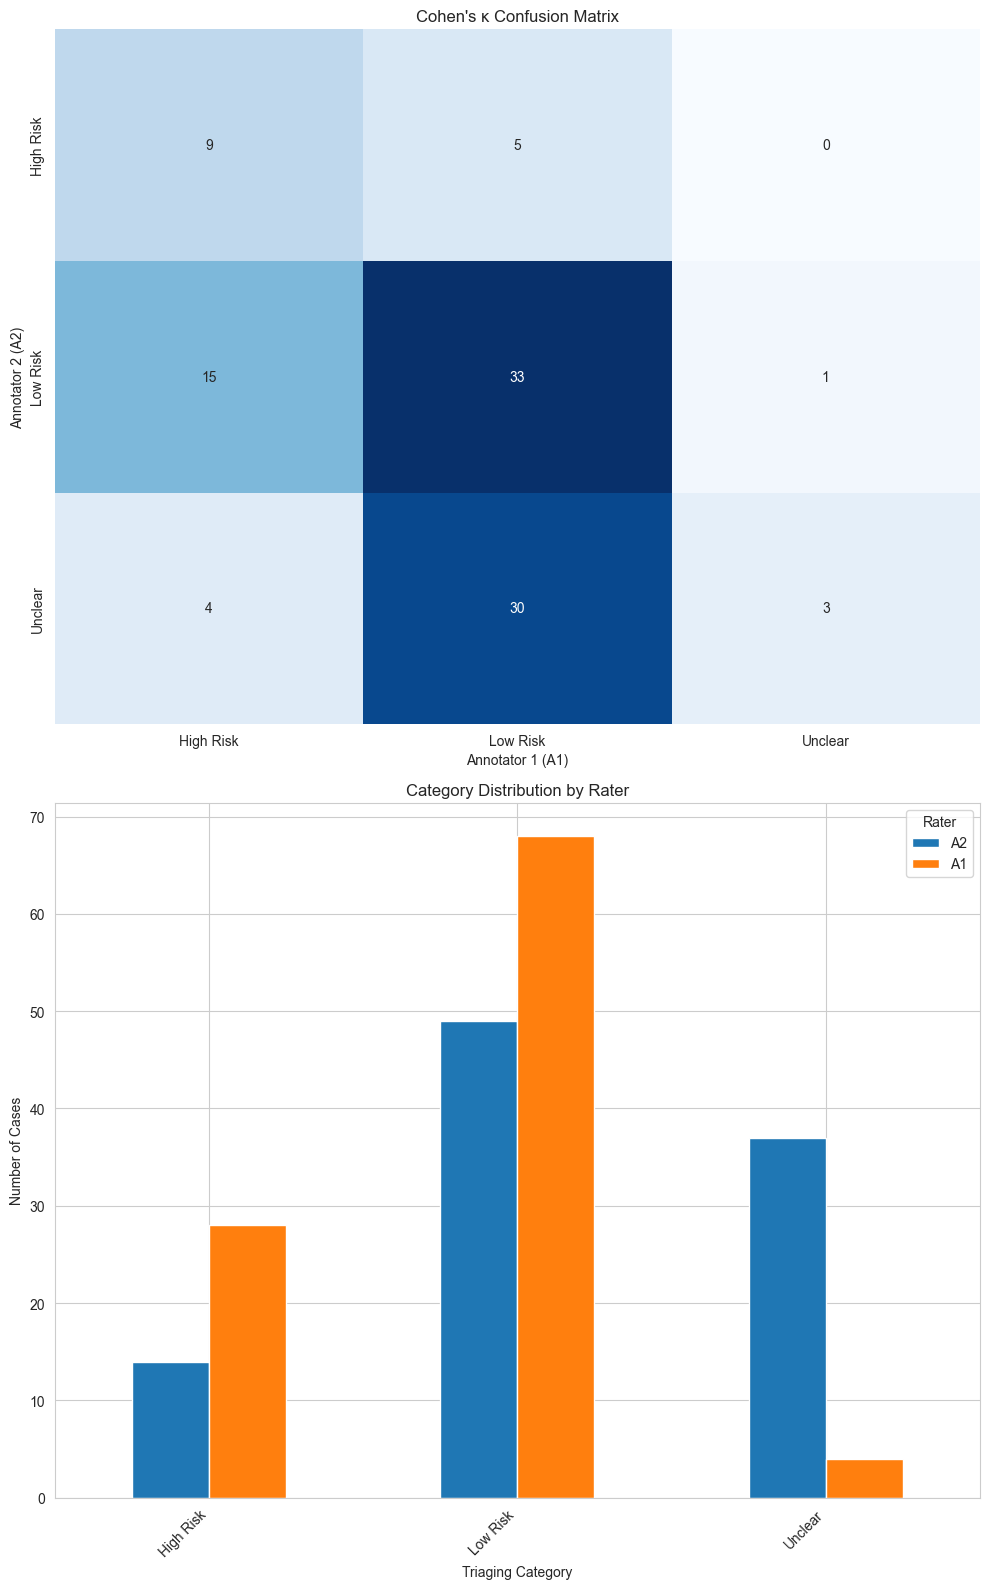

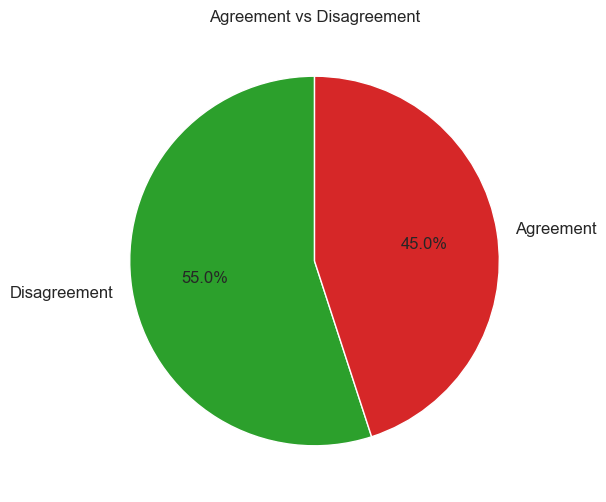

In [ ]:
# Visualization of inter-rater reliability results
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Confusion matrix heatmap
sns.heatmap(
    confusion_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=axes[0]
)
axes[0].set_title("Cohen's κ Confusion Matrix")
axes[0].set_xlabel("Annotator 1 (A1)")
axes[0].set_ylabel("Annotator 2 (A2)")

# Category distribution comparison
category_distribution = pd.DataFrame({
    'A2': df_merged['Triaging_prasanthan'].value_counts().reindex(all_categories, fill_value=0),
    'A1': df_merged['Triaging_ron'].value_counts().reindex(all_categories, fill_value=0)
})
category_distribution.plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e'])
axes[1].set_title("Category Distribution by Rater")
axes[1].set_xlabel("Triaging Category")
axes[1].set_ylabel("Number of Cases")
axes[1].legend(title="Rater")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Agreement vs disagreement visualization
fig, ax = plt.subplots(figsize=(6, 6))
agreement_counts = df_merged['Agreement'].value_counts().rename({True: 'Agreement', False: 'Disagreement'})
colors = ['#2ca02c', '#d62728']
ax.pie(
    agreement_counts,
    labels=agreement_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)
ax.set_title('Agreement vs Disagreement')
plt.show()
